In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env
from src.optimization.heuristic_greedy import compute_greedy_heuristic
from src.optimization.deterministic_solution import compute_deterministic_solution

%matplotlib inline

In [22]:
def plot_results(env, results_list, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    i_violations = [res['i_constraints_violation'] for res in results_list]
    p_violations = [res['power_flow_constraints_violation'] for res in results_list]
    plt.plot(env.timesteps_str[:-1], i_violations, label='i_violation')
    plt.plot(env.timesteps_str[:-1], p_violations, label='p_violation')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Constraint violations')

    plt.subplot(122)
    rewards = [res['reward'] for res in results_list]
    feeders_price = [res['feeders_power_price'] for res in results_list]
    pvs_price = [res['pvs_power_price'] for res in results_list]
    evs_welfare = [res['evs_social_welfare'] for res in results_list]

    plt.plot(env.timesteps_str[:-1], rewards, label='total reward')
    plt.plot(env.timesteps_str[:-1], feeders_price, label='feeders price')
    plt.plot(env.timesteps_str[:-1], pvs_price, label='PVs price')
    plt.plot(env.timesteps_str[:-1], evs_welfare, label='EVs welfare')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Objective')

### Config and data loading

In [23]:
config = {'path_to_data': './data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line
          }

In [24]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

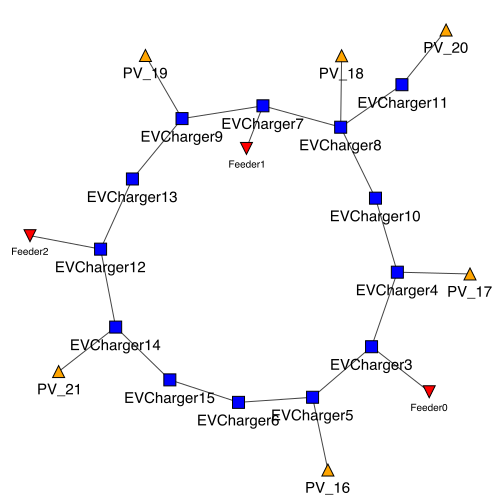

In [25]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata, gym=False)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata, gym=True)               
env.plot_grid(bbox=(0, 0, 500, 500))

### Sample runs using heuristics

Reward = 320.03


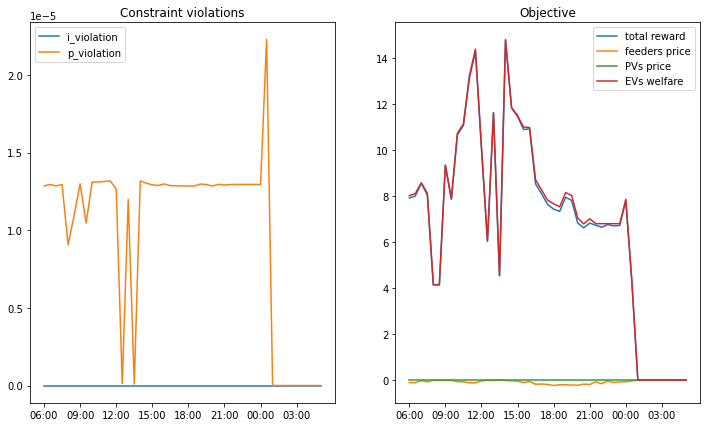

In [26]:
# Greedy heuristic which solves single-timestep OPF
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=False, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

Reward = 318.83


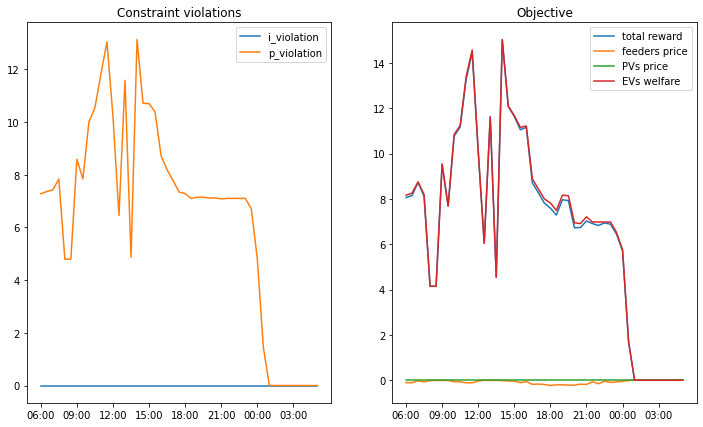

In [27]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=True, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Same simulation but using a deterministic planner

Reward = 358.36


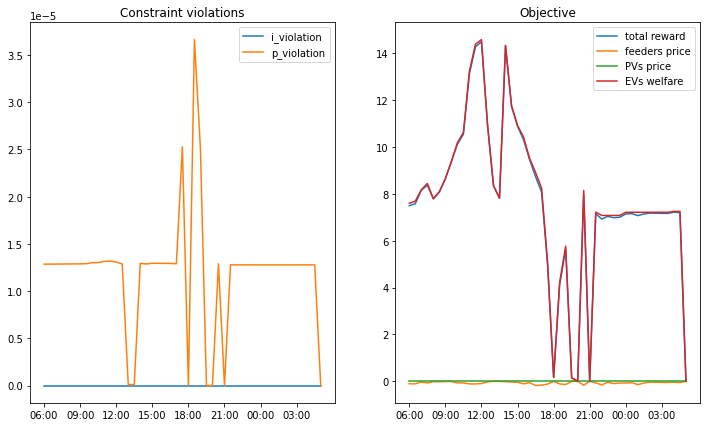

In [28]:
# Deterministic solution solves the full planning problem using perfect knowledge of the future.
# As expected, it receives higher reward.
np.random.seed(42)
env.reset(episode_index=0, train=True)

p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state(uncertainty='deterministic')
p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
                                                     p_ubs[0], v_lbs[0], v_ubs[0], 
                                                     env.conductance_matrix, env.i_max_matrix,
                                                     lossless=False, tee=False)
results_list = []
total_reward = 0
while not env.done:
    result = env.step(p_det[env.t_ind], v_det[env.t_ind])
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### New cool implementation using DDPG

In [39]:
# aaaa
from src.ddpg_frans.ddpg import Buffer, get_actor, get_critic, policy, update_target
import tensorflow as tf

num_states = gym_env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = gym_env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = gym_env.action_space.high[0]
lower_bound = gym_env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

actor_model = get_actor(num_states, num_actions, upper_bound)
critic_model = get_critic(num_states, num_actions)

target_actor = get_actor(num_states, num_actions, upper_bound)
target_critic = get_critic(num_states, num_actions)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(num_states, num_actions, 50000, 64)

Size of State Space ->  110
Size of Action Space ->  44
Max Value of Action ->  10.0
Min Value of Action ->  -5.0


In [44]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = gym_env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, lower_bound, upper_bound, actor_model)[0]
        # Recieve state and reward from environment.
        state, reward, done, info = gym_env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

NameError: in user code:

    File "/Users/fransdeboer/Projects/RL-EVCP/src/ddpg_frans/ddpg.py", line 48, in update  *
        target_actions = target_actor(next_state_batch, training=True)

    NameError: name 'target_actor' is not defined


The goal of the project is to come up with an RL based method that computes nodal powers and voltages that maximize the objective while keeping the constraint violations small.  The above simulations use the benchmarks that you should be comparing to. Clearly, you want to beat the greedy heuristic , but you can't beat the determenistic planner as it is the absolute optimal solution (assuming known future).